# Класифікація обʼєктів новобудови за текстовим описом за допомогою зворотної нейронної мережі

https://www.youtube.com/watch?v=VtRLrQ3Ev-U&ab_channel=freeCodeCamp.org

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from sklearn.model_selection import train_test_split
from translitua import translit
from googletrans import Translator

## Завантаження набору даних

In [41]:
df = pd.read_csv('./real-estate-1677267283070.csv', usecols=['residence', 'developer', 'price', 'attributes/class', 'description'])

In [42]:
df.head()

,residence,developer,attributes/class,description,price
0,ЖК Greenville на Печерську,Greenville,бізнес,Greenville — це об'єднання житлового простору ...,4138800.0
1,Linden Luxury Residences,Budhouse Group,преміум,Розташування Linden Luxury Residences — це сам...,1709400.0
2,БФК OLEGIVSKIY,DIM,бізнес,OLEGIVSKIY — це ексклюзивний багатофункціональ...,3856325.0
3,ЖК Новий Автограф,DIM,комфорт,Між обома будинками комплексу «Новий автограф»...,3269700.0
4,NaN,NaN,NaN,NaN,NaN


In [43]:
df.shape

(100, 5)

In [44]:
df = df.dropna(subset=['attributes/class', 'description'])

In [45]:
df['attributes/class'].unique()

array(['бізнес', 'преміум', 'комфорт', 'економ'], dtype=object)

In [46]:
df.head()

,residence,developer,attributes/class,description,price
0,ЖК Greenville на Печерську,Greenville,бізнес,Greenville — це об'єднання житлового простору ...,4138800.0
1,Linden Luxury Residences,Budhouse Group,преміум,Розташування Linden Luxury Residences — це сам...,1709400.0
2,БФК OLEGIVSKIY,DIM,бізнес,OLEGIVSKIY — це ексклюзивний багатофункціональ...,3856325.0
3,ЖК Новий Автограф,DIM,комфорт,Між обома будинками комплексу «Новий автограф»...,3269700.0
5,БФК А136 Highlight Tower,DIM,бізнес,Житловий комплекс А136 Highlight Tower — предс...,6635250.0


In [47]:
df['class'] = df['attributes/class'].map({ 'бізнес': 1, 'преміум': 2, 'комфорт': 3, 'економ': 4 })

In [48]:
df = df[['description', 'class']]

In [49]:
df.head()

,description,class
0,Greenville — це об'єднання житлового простору ...,1
1,Розташування Linden Luxury Residences — це сам...,2
2,OLEGIVSKIY — це ексклюзивний багатофункціональ...,1
3,Між обома будинками комплексу «Новий автограф»...,3
5,Житловий комплекс А136 Highlight Tower — предс...,1


### Переклад на англійську

In [50]:
translator = Translator()

In [51]:
df = df.head(6)

In [52]:
df

,description,class
0,Greenville — це об'єднання житлового простору ...,1
1,Розташування Linden Luxury Residences — це сам...,2
2,OLEGIVSKIY — це ексклюзивний багатофункціональ...,1
3,Між обома будинками комплексу «Новий автограф»...,3
5,Житловий комплекс А136 Highlight Tower — предс...,1
6,Montreal House будують в діловій частині Голос...,1


In [53]:
list(map(lambda d: len(d), list(df['description'].values)))

[2103, 3732, 3322, 1971, 2429, 2308]

In [54]:
# df['description'] = df['description'].str.slice(0, 100)

In [55]:
df['description'] = df['description'].map(lambda description: (translator.translate(description).text))

In [56]:
df

,description,class
0,Greenville is a combination of living space wi...,1
1,The location of Linden Luxury Residences is th...,2
2,Olegivskiy is an exclusive multifunctional bus...,1
3,Between the two buildings of the New Autograph...,3
5,Highlight Tower A136 residential complex - rep...,1
6,Montreal House is built in the business part o...,1


## Підготовка даних для тренування моделі

### Створення сету характеристик і міток

TODO: використання imblearn.oversampling -> RandomOverSampler для прирівнювання к-сті зразків певного класу

In [57]:
train, val, test = np.split(df.sample(frac=1), [int(0.8 * len(df)), int(0.9 * len(df))])

In [58]:
train.shape, val.shape, test.shape

((4, 2), (1, 2), (1, 2))

In [59]:
df.head()

,description,class
0,Greenville is a combination of living space wi...,1
1,The location of Linden Luxury Residences is th...,2
2,Olegivskiy is an exclusive multifunctional bus...,1
3,Between the two buildings of the New Autograph...,3
5,Highlight Tower A136 residential complex - rep...,1


In [60]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  dataframe = dataframe.copy()
  labels = dataframe.pop('class')
  df = dataframe['description']
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [61]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

In [62]:
embed = hub.load("https://tfhub.dev/google/nnlm-en-dim50/2")

In [63]:
hub_layer = hub.KerasLayer(embed, dtype=tf.string, trainable=True)

In [64]:
# hub_layer(list(train_data)[0][0]['description'])

In [65]:
model = Sequential()

model.add(hub_layer)
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [66]:
model.compile(optimizer=Adam(learning_rate=0.001), loss=BinaryCrossentropy(), metrics=['accuracy'])

In [67]:
model.evaluate(train_data)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


1/1 [==============================] - 1s 604ms/step - loss: 0.6819 - accuracy: 0.2500


[0.6819230318069458, 0.25]

In [68]:
history = model.fit(train_data, epochs=10, validation_data=valid_data)

Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 0.6819 - accuracy: 0.2500 - val_loss: 0.7314 - val_accuracy: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 1s 840ms/step - loss: 0.6207 - accuracy: 0.5000 - val_loss: 0.6515 - val_accuracy: 0.0000e+00
Epoch 3/10
1/1 [==============================] - 1s 877ms/step - loss: 0.5663 - accuracy: 0.7500 - val_loss: 0.5708 - val_accuracy: 0.0000e+00
Epoch 4/10
1/1 [==============================] - 1s 839ms/step - loss: 0.5155 - accuracy: 0.7500 - val_loss: 0.4906 - val_accuracy: 0.0000e+00
Epoch 5/10
1/1 [==============================] - 1s 823ms/step - loss: 0.4647 - accuracy: 0.7500 - val_loss: 0.4105 - val_accuracy: 0.0000e+00
Epoch 6/10
1/1 [==============================] - 1s 868ms/step - loss: 0.4128 - accuracy: 0.7500 - val_loss: 0.3313 - val_accuracy: 0.0000e+00
Epoch 7/10
1/1 [==============================] - 1s 857ms/step - loss: 0.3614 - accuracy: 0.7500 - val_loss: 0.2521 - val_accuracy: 0.0000

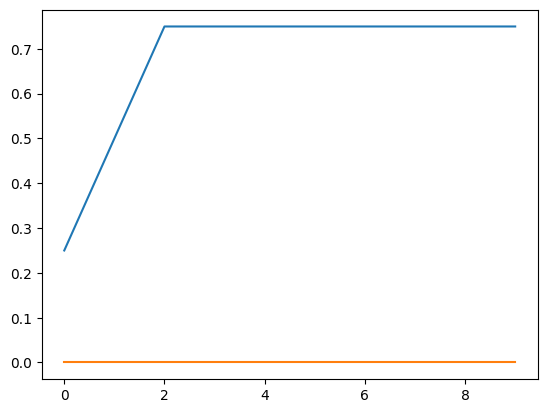

In [69]:
plt.plot(history.history['accuracy'], label="Точність")
plt.plot(history.history['val_accuracy'], label="Валідаційна точність")

plt.show()

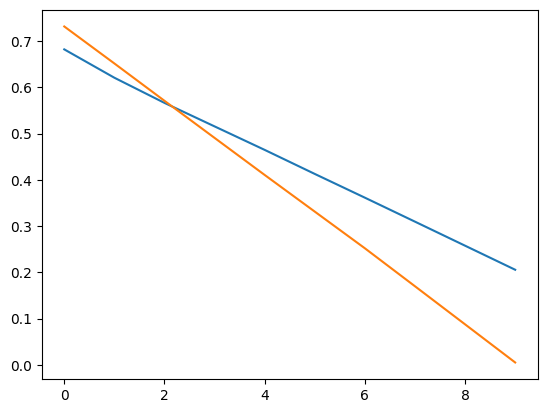

In [70]:
plt.plot(history.history['loss'], label="Втрати")
plt.plot(history.history['val_loss'], label="Валідаційні втрати")

plt.show()

In [71]:
model.evaluate(test_data)

1/1 [==============================] - 0s 140ms/step - loss: 0.5113 - accuracy: 1.0000


[0.5112739205360413, 1.0]

TODO: also use LSTM https://www.youtube.com/watch?v=VtRLrQ3Ev-U&ab_channel=freeCodeCamp.org